In [1]:
import PKoopmanDL as pkdl
import numpy as np
import matplotlib.pyplot as plt
import torch

# read the config file
config_file = "kdv.json"
solver = pkdl.ParamKoopmanDLSolverWrapper(config_file)

# set up the grid
Nx = 128
x_max = torch.pi
x_min = -torch.pi
x_step = (x_max - x_min) / (Nx - 1)
x_grid = torch.linspace(x_min, x_max, Nx).unsqueeze(0)

def sample_func(row_size, col_size):
  assert (col_size == Nx)
  x = x_grid.expand(row_size, Nx)
  # torch.manual_seed(0)
  uniform = torch.tensor([1.0, 1.0, 1.0])
  b = torch.distributions.Dirichlet(uniform).sample((row_size,))
  b1 = b[:, 0].view(-1, 1)
  b2 = b[:, 1].view(-1, 1)
  b3 = b[:, 2].view(-1, 1)
  eta = b1 * torch.exp(-(x - torch.pi / 2)**2) - b2 * torch.sin(
      x / 2)**2 + b3 * torch.exp(-(x + torch.pi / 2)**2)
  return eta

def mass_func(x):
  mass = torch.sum(x, dim=1, keepdim=True) * x_step
  return mass
  
def momentum_func(x):
  momentum = torch.sum(x **2, dim=1, keepdim=True) * x_step
  return momentum
  

def nontrain_func(x):
  one = torch.ones((x.shape[0], 1))
  mass = mass_func(x)
  momentum = momentum_func(x)
  return torch.cat((one, mass, momentum), dim=1)
  

# set up the solver
solver.load_dataset_setup("data/kdv_dataset.pt", nontrain_func, sample_func)
K = solver.solve()
koopman_dynamics = pkdl.DiscreteDynamics(K, solver.dynamics.dim, solver.dynamics.param_dim)

2024-11-16 18:46:56,394 PKoopmanDL: [INFO] CUDA is available. GPU is being used.
2024-11-16 18:46:56,623 PKoopmanDL: [INFO] [ParamKoopmanDLSolver] Solving...
Training: 100%|██████████| 2000/2000 [00:36<00:00, 54.17it/s, train_loss=7.06e-03, val_loss=7.18e-03]


## Prediction

In [ ]:

# predict
param = solver.train_dataset.dataset.data_param[0].unsqueeze(0)
dataset_predict = pkdl.DynamicsDataSet(solver.dynamics)
dataset_predict.generate_data(1, solver.traj_len, solver.x_min, solver.x_max, param)
x0 = torch.unsqueeze(dataset_predict.data_x[0], dim=0)
p = koopman_dynamics.traj(solver.dictionary(x0), param, solver.traj_len)
x_est_traj = p[0, :, :].detach().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(12,5))  
t_grid = np.arange(0, solver.traj_len)
x_traj = solver.dynamics.traj(x0, param, solver.traj_len)[0, :, :]
mass_traj = torch.sum(x_traj, dim=1, keepdim=True) * x_step
mass_traj = mass_traj.detach().numpy()
momentum_traj = torch.sum(x_traj **2, dim=1, keepdim=True) * x_step
momentum_traj = momentum_traj.detach().numpy()

ax1.plot(t_grid, mass_traj[:,0], 'k-', label='Exact', markevery=2)
ax1.plot(t_grid, x_est_traj[:,1], 'gs', label='ParamKoopman', markevery=2)

ax2.plot(t_grid, momentum_traj[:,0], 'k-', label='Exact', markevery=2)
ax2.plot(t_grid, x_est_traj[:,2], 'gs', label='ParamKoopman', markevery=2)

ax1.set_xlabel(r"$n$")
ax1.set_ylabel(r"$x_{1}(n)$")
ax1.legend(loc='best',prop={'size':14})

ax2.set_xlabel(r"$n$")
ax2.set_ylabel(r"$x_{2}(n)$")
ax2.legend(loc='best',prop={'size':14})

## Solve the Tracking Problem

In [3]:
traj_len = solver.traj_len
t_step = solver.t_step
target_dim = 2
time_horizon = 3
lambda_param = 0.0

state0 = torch.zeros(solver.dynamics.dim) + 0.2
mass_ref = torch.zeros(traj_len, 1)
momentum_ref = torch.zeros(traj_len, 1)


for i in range(traj_len):
  if i > traj_len / 2:
    mass_ref[i, :] = 3.16
    momentum_ref[i, :] = 1.58
  else:
    mass_ref[i, :] = mass_func(state0.unsqueeze(0))
    momentum_ref[i, :] = momentum_func(state0.unsqueeze(0))


# mass_solver = pkdl.KoopmanMPCSolver(solver.dynamics, K, solver.dictionary, mass_ref, time_horizon, 1, lambda_param)
# mass_controls, mass_traj = mass_solver.solve(state0, -1, 1)

momentum_solver = pkdl.KoopmanMPCSolver(solver.dynamics, K, solver.dictionary, momentum_ref, time_horizon, 2, lambda_param)
momentum_controls, momentum_state_traj = momentum_solver.solve(state0, -1, 1)


2024-11-16 18:48:28,665 PKoopmanDL: [INFO] [KoopmanMPCSolver] Solving the optimal control problem...
Solving:  86%|████████▌ | 6/7 [00:32<00:05,  5.39s/it, loss=7.60e+00]


/tmp/ipykernel_1950962/3709981061.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='best',prop={'size':14})


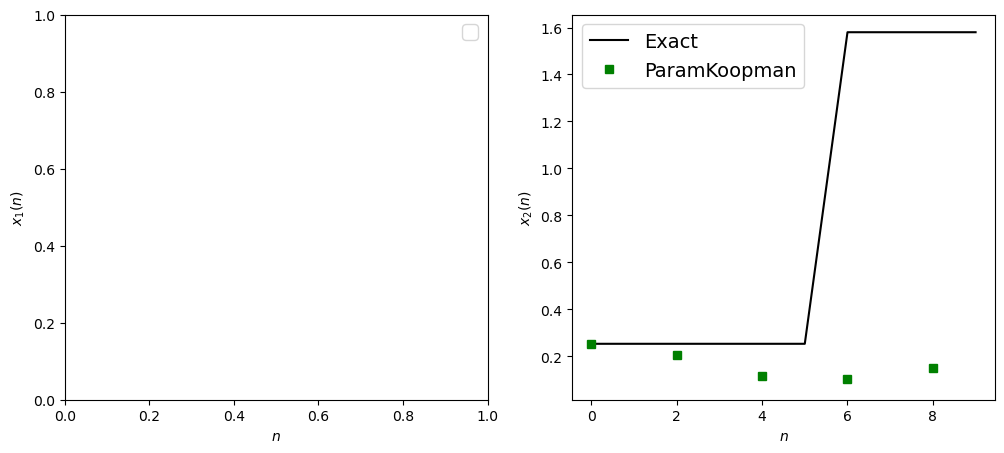

In [4]:

momentum_traj = koopman_dynamics.traj(solver.dictionary(state0.unsqueeze(0)), momentum_controls.to(torch.float32), solver.traj_len)
t_grid = np.arange(0, traj_len)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(12,5))  
# ax1.plot(t_grid, mass_ref[:,0], 'k-', label='Exact', markevery=2)
# ax1.plot(t_grid, mass_traj[:,1], 'gs', label='ParamKoopman', markevery=2)

ax2.plot(t_grid, momentum_ref.detach().numpy()[:,0], 'k-', label='Exact', markevery=2)
ax2.plot(t_grid, momentum_traj.detach().numpy()[0,:,2], 'gs', label='ParamKoopman', markevery=2)

ax1.set_xlabel(r"$n$")
ax1.set_ylabel(r"$x_{1}(n)$")
ax1.legend(loc='best',prop={'size':14})

ax2.set_xlabel(r"$n$")
ax2.set_ylabel(r"$x_{2}(n)$")
ax2.legend(loc='best',prop={'size':14})